In [7]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
peft_model_id = "/home/ljc/representation-engineering/model"

model = AutoModelForCausalLM.from_pretrained(model_id)
model.eval()
tokenizer=AutoTokenizer.from_pretrained(model_id)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
model.load_adapter(peft_model_id)


In [9]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=8, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=8, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): lora.Linear(
            (base_layer): Linear(in_features=4096, out_features=1024, bias=False)
            (lora_dropout): Module

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


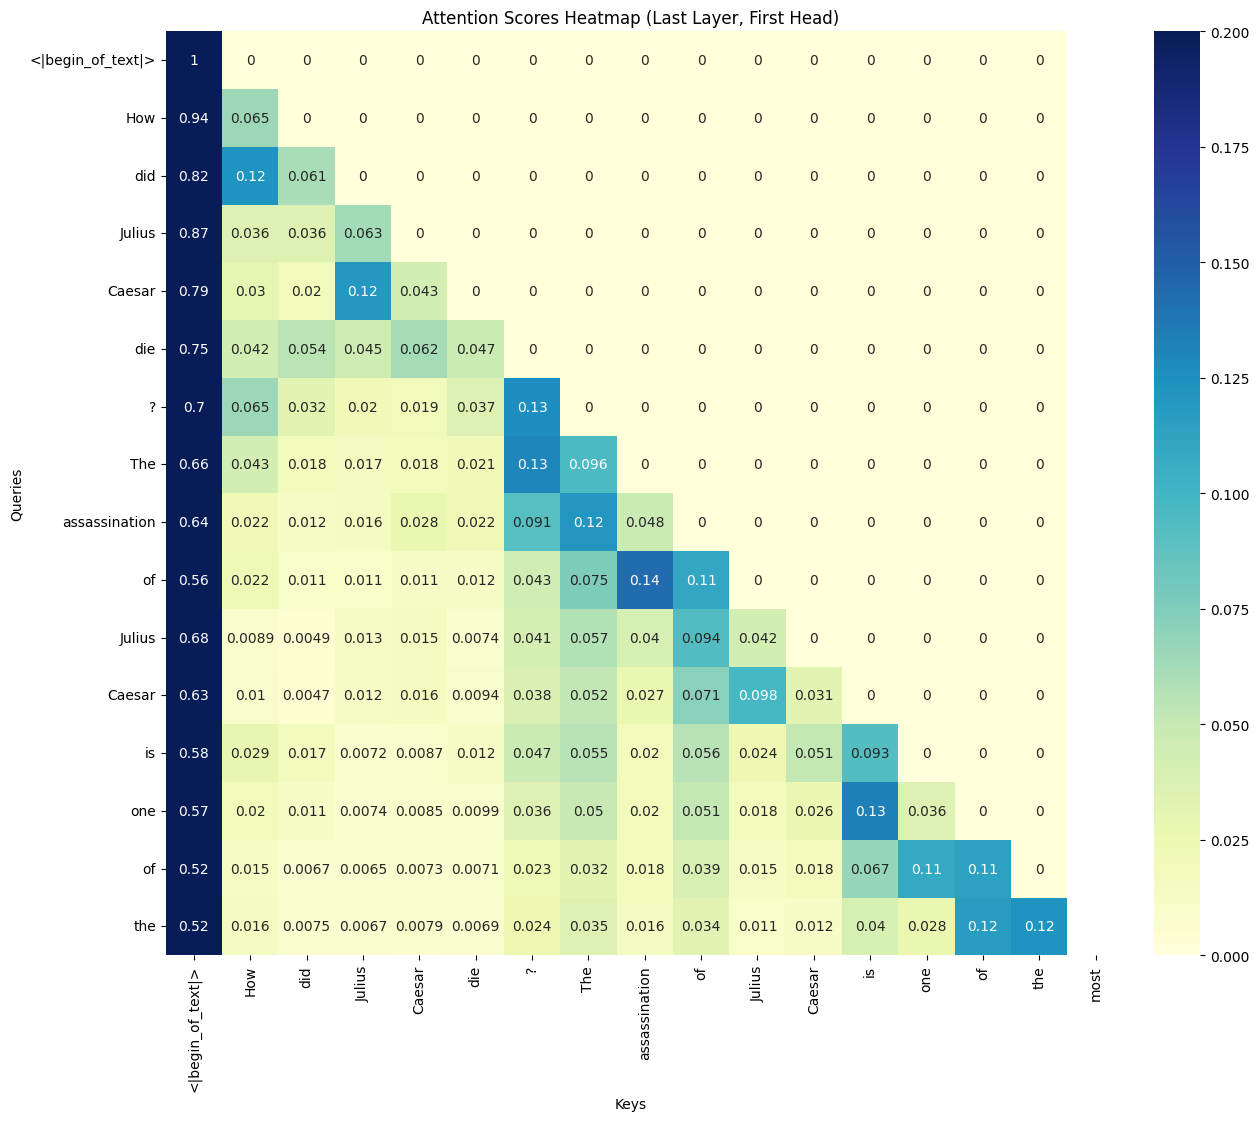

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
# 输入文本
input_text = "How did Julius Caesar die?"

# 将输入文本编码为 token
inputs = tokenizer(input_text, return_tensors="pt")

# 生成 50 个新 token
generate_output = model.generate(inputs['input_ids'], max_length=inputs['input_ids'].shape[1] + 10, output_attentions=True, return_dict_in_generate=True)

# 获取生成的所有 token 的注意力值
attentions = generate_output.attentions  # 这是一个包含所有生成步骤的注意力值的元组
generated_ids = generate_output.sequences[0]  # 获取生成的 token 序列

# 获取所有 token 标签
tokens = tokenizer.convert_ids_to_tokens(generated_ids)
tokens = [token.replace('Ġ', '') for token in tokens]

# 选择特定层和特定注意力头进行可视化
layer_index = 0  # 最后一层，也可以选择其他层，例如 0 表示第一层
head_index = 0  # 第一个注意力头，也可以选择其他头

# 注意力值的形状是 (num_generate_steps, batch_size, num_heads, sequence_length, sequence_length)
# 将所有生成步骤的注意力值扩展到相同的尺寸并拼接起来
all_attention = []
max_seq_length = max([step[layer_index][0][head_index].shape[-1] for step in attentions])

for step in attentions:
    attn = step[layer_index][0].detach().cpu().numpy()  # 形状 (num_heads, sequence_length, sequence_length)
    attn = attn.mean(axis=0)  # 对所有注意力头取均值，形状 (sequence_length, sequence_length)
    # attn = attn[:,1:]
    # attn = step[layer_index][0][head_index].detach().cpu().numpy()
    pad_width = max_seq_length - attn.shape[-1]
    if pad_width > 0:
        attn = np.pad(attn, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
    all_attention.append(attn)

# 将注意力值拼接成一个完整的矩阵
complete_attention = np.concatenate(all_attention, axis=0)

# 创建热力图
plt.figure(figsize=(15, 12))
sns.heatmap(complete_attention, annot=True, cmap='YlGnBu', xticklabels=tokens, yticklabels=tokens[:complete_attention.shape[0]], vmin=0, vmax=0.2)
plt.title('Attention Scores Heatmap (Last Layer, First Head)')
plt.xlabel('Keys')
plt.ylabel('Queries')
plt.show()

In [ ]:

input_text = "How did Julius Caesar die?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
with torch.no_grad():
    outputs = model.generate(
        input_ids,
        output_scores=True,
        return_dict_in_generate=True,
        max_new_tokens=100,
        )
tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

In [ ]:

input_text = "How did Julius Caesar die?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids
with torch.no_grad():
    outputs = model.generate(
        input_ids,
        output_scores=True,
        return_dict_in_generate=True,
        max_new_tokens=20,
        )
tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)